# Обучаем!
В работе американцев использовались линейные модели. Они показали себя как самые лучшие. Но не лишним будет попробовать и еще что-нибудь.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import string
from bs4 import BeautifulSoup
import copy
import unicodedata
import sys
import requests
from pymystem3 import Mystem
import warnings
warnings.simplefilter("ignore")

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

In [3]:
def top_features(importance_array, n_features, names, title='feature importance', plot=True):
    d = pd.DataFrame(data = importance_array, index = names, columns=['Importance'])
    d = d.sort_values(by = 'Importance', ascending = False)
    if plot is True:
        return d[0:n_features].plot(kind='bar', title=title)
    else:
        return d[0:n_features]

## Препроцессинг

In [4]:
#Импортируем дату (вдруг она отличается)
train = pd.read_csv('https://github.com/Chernechev/RussianFWords/raw/main/train.csv', index_col='Unnamed: 0')
test = pd.read_csv('https://github.com/Chernechev/RussianFWords/raw/main/test.csv', index_col='Unnamed: 0')

In [5]:
y_train = train['target']
y_test = test['target']
X_train = train.drop(['word', 'stem', 'detagged', 'ipa', 'target', 'sounds'], axis=1)
X_test = test.drop(['word', 'stem', 'detagged', 'ipa', 'target', 'sounds'], axis=1)

In [6]:
column_names = ['name', 'model', 
                'acc train', 'acc test', 
                'preci train', 'preci test', 
                'recall train', 'recall test', 
                'auc train', 'auc test']

def model_quality(model, name, training=X_train, testing=X_test):
    plot_roc_curve(model, training, y_train)
    plt.gca().set_title(f"train score for {name}")

    plot_roc_curve(model, testing, y_test)
    plt.gca().set_title(f"test score {name}")
    
    pres_req_train = precision_recall_fscore_support(y_train, model.predict(training), average='macro')
    pres_req_test = precision_recall_fscore_support(y_test, model.predict(testing), average='macro')
    
    stat_list = [name, model,
                 '{0:.3f}'.format(model.score(training, y_train)), 
                 '{0:.3f}'.format(model.score(testing, y_test)),
                 '{0:.3f}'.format(pres_req_train[0]),
                 '{0:.3f}'.format(pres_req_test[0]),
                 '{0:.3f}'.format(pres_req_train[1]),
                 '{0:.3f}'.format(pres_req_test[1]),
                 '{0:.3f}'.format(roc_auc_score(y_train, model.predict(training))),
                 '{0:.3f}'.format(roc_auc_score(y_test, model.predict(testing)))]
    
    message = f"""
    Name: {stat_list[0]}
    Model: {stat_list[1]}
    
    Accuracy: 
    train = {stat_list[2]}
    test = {stat_list[3]}
    
    Precision: 
    train = {stat_list[4]}
    test = {stat_list[5]}
    
    Recall: 
    train = {stat_list[6]}
    test = {stat_list[7]}
    """
    print(message)
    
    return pd.DataFrame(np.array(stat_list)[np.newaxis], columns=column_names)


## Обучим только на тегах из Вики

In [7]:
wikitags = X_train.columns[49:103]
wikitag_train = X_train[wikitags]
wikitag_test = X_test[wikitags]

In [8]:
wikitag_train.head()

,бранн.,вульг.,высок.,гипокор.,груб.,детск.,диал.,дисфм.,жарг.,ирон.,...,унич.,усилит.,устар.,фам.,школьн.,шутл.,эвф.,экзот.,экспр.,эррат.
1723,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
wikiLog = LogisticRegression().fit(wikitag_train, y_train)


    Name: wikitags
    Model: LogisticRegression()
    
    Accuracy: 
    train = 0.908
    test = 0.917
    
    Precision: 
    train = 0.454
    test = 0.459
    
    Recall: 
    train = 0.500
    test = 0.500
    


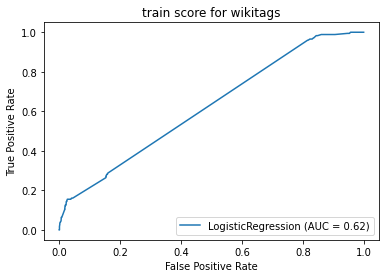

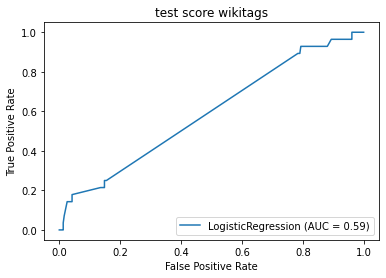

In [10]:
comparison_matrix = model_quality(wikiLog, 'wikitags', training=wikitag_train, testing=wikitag_test)

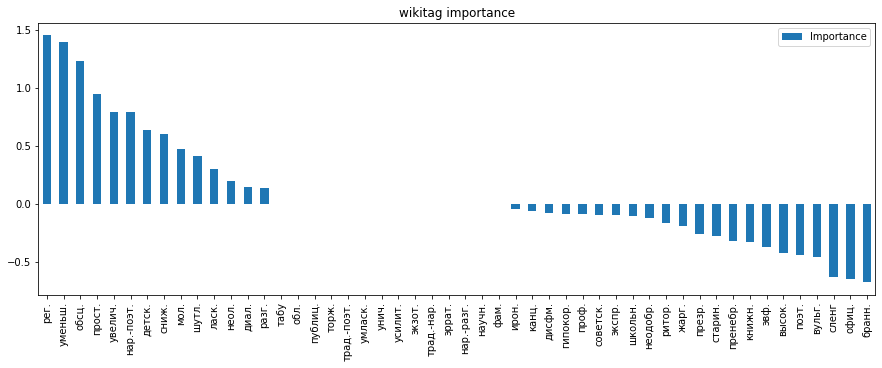

In [11]:
top_features(wikiLog.coef_.T, 50, title='wikitag importance', names=wikitags)
plt.gcf().set_size_inches((15,5))

In [12]:
train[train['бранн.'] == 1]

,word,stem_bastard,stem,detagged,length,ngramm к,ngramm у,ngramm п,ngramm а,ngramm ч,...,sound rʲ,sound ʐ,sound k,sound ʉ,sound ʊ,sound mʲ,sound dʲ,sound lʲ,repeated,target
941,мымра,0,мымра_NOUN,мымра,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2178,чучело,0,чучело_NOUN,чучело,6,0,1,0,0,2,...,0,0,0,1,0,0,0,0,0,0
1763,собака,0,собака_NOUN,собака,6,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
671,клуша,0,клуша_NOUN,клуша,5,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
469,жопа,0,жопа_NOUN,жопа,4,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
293,гнида,0,гнида_NOUN,гнида,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Есть проблема с "рег." – там есть, например, слово "море" (одно из его значений – региональное). Но ML сам с этим справится.
Другая проблема – с "нар.-поэт." и "увелич.". Там есть только одно слово, поэтому машина переобучается

#### Логистическая Регрессия

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Logistic = Pipeline([('scaler', StandardScaler()), ('est', LogisticRegression())])
Logistic.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('est', LogisticRegression())])

In [14]:
from sklearn.model_selection import learning_curve

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
def plot_learning_curve(pipe, X, y):
    
    train_sizes = np.linspace(0.01, 1, 20)
    N_train, val_train, val_test = learning_curve(pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('Acc')
    plt.legend()


    Name: logistic
    Model: Pipeline(steps=[('scaler', StandardScaler()), ('est', LogisticRegression())])
    
    Accuracy: 
    train = 0.943
    test = 0.896
    
    Precision: 
    train = 0.854
    test = 0.662
    
    Recall: 
    train = 0.770
    test = 0.667
    


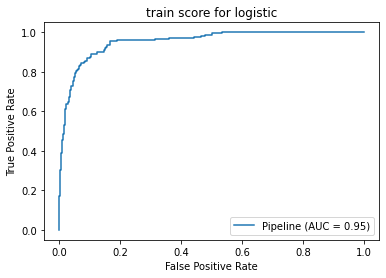

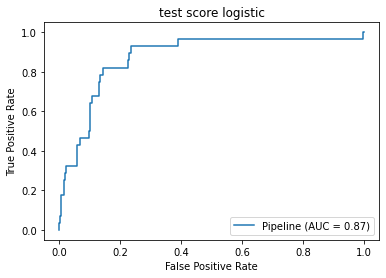

In [15]:
comparison_matrix = comparison_matrix.append(model_quality(Logistic, 'logistic'))

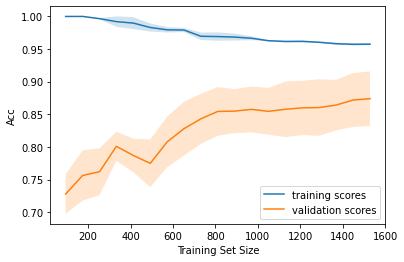

In [16]:
plot_learning_curve(Logistic, X_train, y_train)

In [17]:
def get_with_feature(feature):
    """Возвращает слова, имеющие этот признак. Только для даммис."""
    
    return X_train[X_train[feature] != 0]

#### Forest

Переобучается

In [18]:
Forest = Pipeline([('scaler', StandardScaler()), ('est', RandomForestClassifier(random_state=42))])
Forest.fit(X_train, y_train)
Forest.score(X_test,y_test)

0.9230769230769231


    Name: forest
    Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('est', RandomForestClassifier(random_state=42))])
    
    Accuracy: 
    train = 1.000
    test = 0.923
    
    Precision: 
    train = 1.000
    test = 0.750
    
    Recall: 
    train = 1.000
    test = 0.666
    


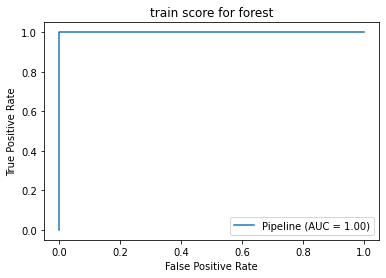

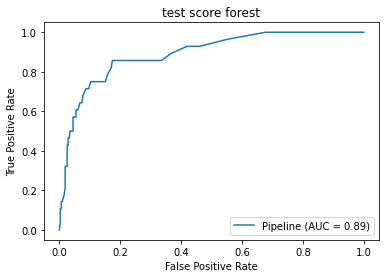

In [19]:
comparison_matrix = comparison_matrix.append(model_quality(Forest, 'forest'))

## Какие результаты?

In [20]:
coefs_logistic = pd.DataFrame(Logistic['est'].coef_, columns=X_train.columns)

In [21]:
coefs_logistic['repeated']

0    0.22185
Name: repeated, dtype: float64

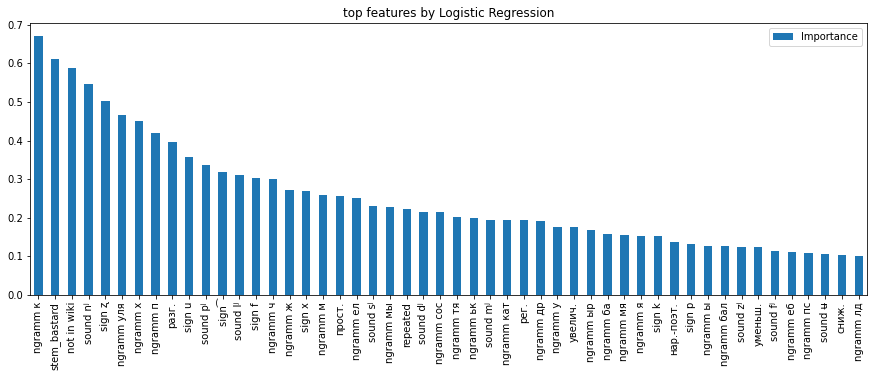

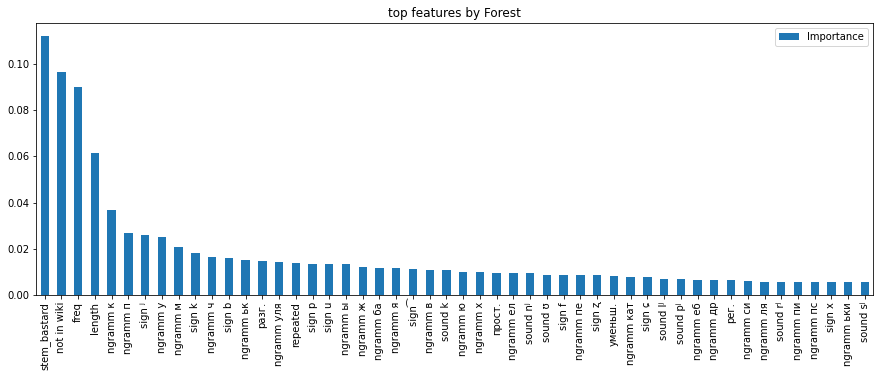

In [22]:
top_features(Logistic['est'].coef_.T, 50, title='top features by Logistic Regression', names=X_train.columns)
plt.gcf().set_size_inches((15,5))

top_features(Forest['est'].feature_importances_.T, 50, title='top features by Forest', names=X_train.columns)
plt.gcf().set_size_inches((15,5))

#### SVM

Дает улучшение качества классификации

In [23]:
from sklearn.svm import SVC
svc = Pipeline([('scaler', StandardScaler()), ('est', SVC())])
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

0.9408284023668639


    Name: svc
    Model: Pipeline(steps=[('scaler', StandardScaler()), ('est', SVC())])
    
    Accuracy: 
    train = 0.959
    test = 0.941
    
    Precision: 
    train = 0.926
    test = 0.838
    
    Recall: 
    train = 0.812
    test = 0.724
    


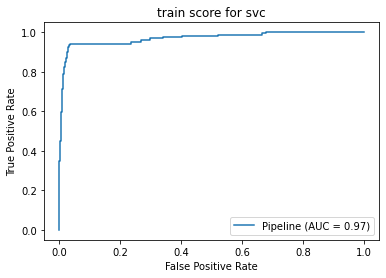

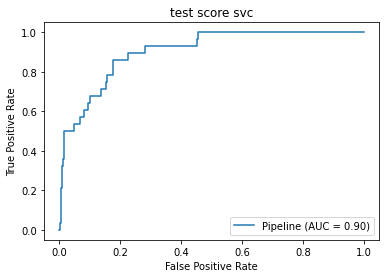

In [24]:
comparison_matrix = comparison_matrix.append(model_quality(svc, 'svc'))

In [25]:
comparison_matrix

,name,model,acc train,acc test,preci train,preci test,recall train,recall test,auc train,auc test
0,wikitags,LogisticRegression(),0.908,0.917,0.454,0.459,0.500,0.500,0.500,0.500
0,logistic,"(StandardScaler(), LogisticRegression())",0.943,0.896,0.854,0.662,0.770,0.667,0.770,0.667
0,forest,"(StandardScaler(), (DecisionTreeClassifier(max...",1.000,0.923,1.000,0.750,1.000,0.666,1.000,0.666
0,svc,"(StandardScaler(), SVC())",0.959,0.941,0.926,0.838,0.812,0.724,0.812,0.724
